In [524]:
import csv
import pandas as pd
import os
import requests
from datetime import datetime, timedelta
import numpy as np

In [525]:
year = 2025
month = 2

folder = f"{year}{str(month).zfill(2)}_lmp_data"
os.makedirs(folder, exist_ok=True)

start_date = datetime(year, month, 1)

# Loop through each day until the month changes
date = start_date
while date.month == month:
    date_str = date.strftime("%Y%m%d")
    url = f"https://docs.misoenergy.org/marketreports/{date_str}_rt_lmp_final.csv"
    local_path = os.path.join(folder, f"{date_str}_rt_lmp_final.csv")

    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(local_path, 'wb') as f:
                f.write(response.content)
        else:
            print(f"Failed ({response.status_code}): {date_str}")
    except Exception as e:
        print(f"Error on {date_str}: {e}")

    date += timedelta(days=1)

In [526]:
# Folders
clean_folder = "2025_lmp_data_cleaned"
os.makedirs(clean_folder, exist_ok=True)
cleaned_file_path = os.path.join(clean_folder, 'cleaned_combined.csv')

with open(cleaned_file_path, 'w', newline='') as outfile:
    writer = csv.writer(outfile)

    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)

        if not filename.endswith('.csv'):
            continue

        with open(file_path, 'r', newline='') as infile:
            reader = csv.reader(infile)
            lines = list(reader)

            if len(lines) < 5:
                continue  # skip malformed files

            actual_date = lines[1][0].strip()  # E.g. '2/1/2025'
            header = lines[3] + ['Date']
            writer.writerow(header)

            for row in lines[4:]:
                writer.writerow(row + [actual_date])

print("Cleaned file created with actual date column.")

Cleaned file created with actual date column.


In [527]:
def final_df(lmp= True):
    clean_folder = "2025_lmp_data_cleaned"
    x = pd.read_csv("2025_lmp_data_cleaned/cleaned_combined.csv")

    #pd datetime
    x['Date'] = pd.to_datetime(x['Date'])
    x.reset_index(inplace=True)

    #store date and index
    y= x['Date']

    #rename columns
    x.drop(['Date'], axis=1, inplace=True)
    x.columns = x.iloc[0]
    x = x[1:]

    #merge

    final = pd.merge(x,y, left_index=True, right_index=True)


    #date data
    final['day'] = final['Date'].dt.day
    final['month'] = final['Date'].dt.month
    final['day_name'] = final['Date'].dt.day_name()
    final['weekend'] = final['Date'].dt.weekday

    final = final[final['Type'] != 'Type']
    final.ffill(inplace=True)

    final.set_index('Date', inplace=True)

    final.sort_index(inplace=True)

    final['is_weekend'] = np.where(final['weekend'].isin([5, 6]), 1, 0)


    if lmp == True:
        final = final[final['Value']=='LMP']




    return final

In [529]:
def calculate_summary(df, metric= 'mean', plot = True):
    df = df.copy()
    df = df.reset_index()

    hours=  list(df.columns)[3:27]
    df_melted = df.melt(
    id_vars=['Date', 'Node', 'Type', 'Value', 'is_weekend'],
    value_vars=hours,
    var_name='Hour',
    value_name='LMP'
    )

    df_melted['Hour'] = df_melted['Hour'].str.extract(r'(\d+)').astype(int)
    df_melted['LMP'] = pd.to_numeric(df_melted['LMP'], errors='coerce')

    pv = df_melted.pivot_table(
        index='is_weekend',
        columns='Hour',
        values='LMP',
        aggfunc=f"{metric}"
    )

    pv.reset_index(drop='is_weekend', inplace=True)

    pv = pv.T

    pv.columns = ['Weekday', 'Weekend']

    if plot:
        pv.plot()

In [530]:
df= final_df(lmp= True)

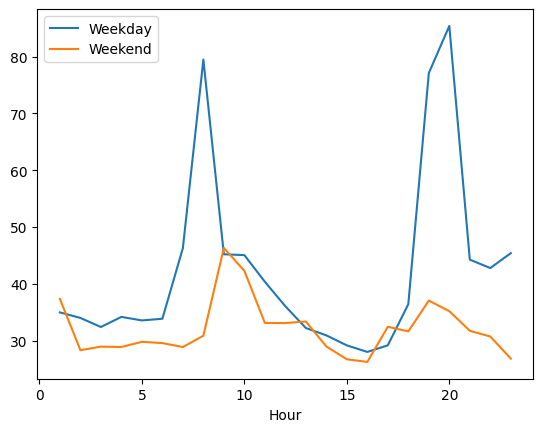

In [531]:
calculate_summary(df, metric= 'mean', plot = True)

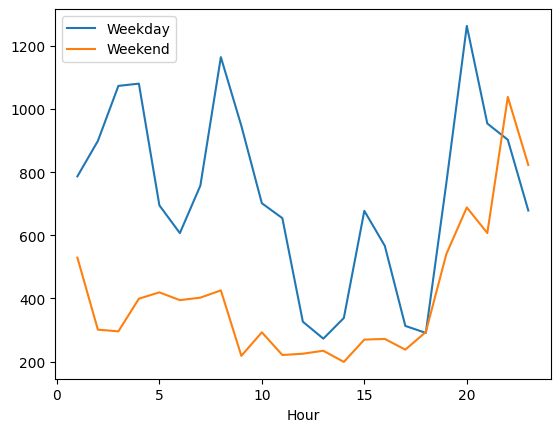

In [532]:
calculate_summary(df, metric='max', plot = True)

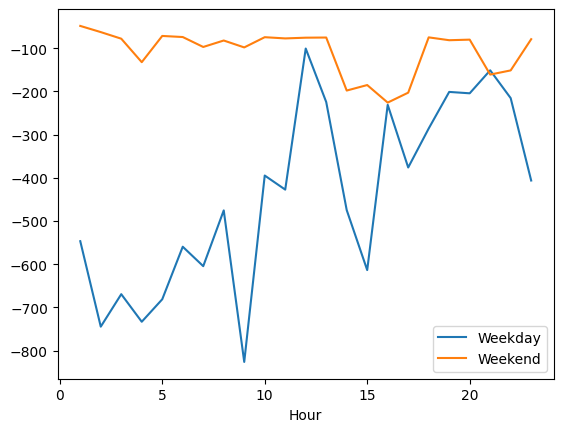

In [533]:
calculate_summary(df, metric='min', plot = True)

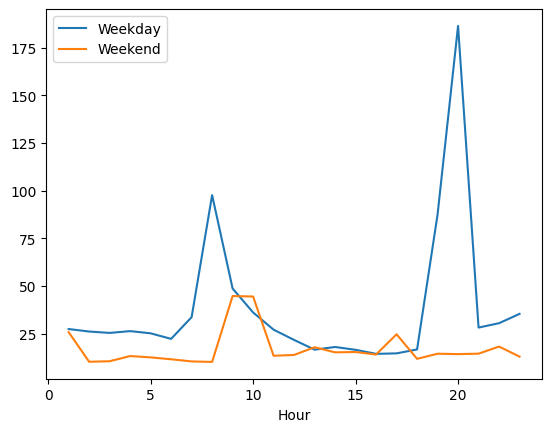

In [534]:
calculate_summary(df, metric='std', plot = True)

2b.
<small>

For the weekday we see sharp spikes at around 8:00 AM and 8:00 PM where as in the weekend the LMP is less volatile in terms of mean and standard deviation. We can also see that the minimum LMP is way lower across the hours for a weekday then a weekend and the max is a lot higher in that same regard. These metrics can help us understand how to value FTR pricing across the most volatile hours. Hours that are relatively low std, and constant mean across time should be valued less for a FTR. As a buyer we want to increase the volatilty so we would buy for hours that that reflect the extreme changes to capitalize.

In [535]:
import os
os.getcwd()

'/Users/kunjshah/Downloads/MISO'